In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
# Для начала масштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование — вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [4]:
# Найдём собственные векторы и собственные значения (англ. Eigenvalues)
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения в порядке убывания:
(437.77467247979905, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.1045707202107, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.01353133569719, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.107225464292897, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


In [5]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную, то есть накапливаемую, дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329986, 22.85076178670179, 3.668921889282866, 0.517870910715483]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [6]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [7]:
# Сформируем новую матрицу «объекты-признаки»
Z = X_.dot(W)

In [8]:
Z.shape

(150, 2)

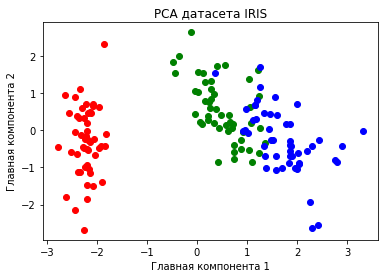

In [9]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [10]:
def PCA_as_SVD(arr, m):
    arr_ = arr.astype(float)
    rows, cols = arr_.shape

    means = arr_.mean(0)
    for i in range(rows):
        for j in range(cols):
            arr_[i, j] -= means[j]

    std = np.std(arr_, axis=0)
    for i in range(cols):
        for j in range(rows):
            arr_[j][i] /= std[i]
    
    u, s, vh = np.linalg.svd(arr_)
    V = np.transpose(vh)
    W = V[:, :m]
    Z = arr_ @ W
    
    return Z

In [11]:
Z_1 = PCA_as_SVD(X, 2)
np.allclose(Z, Z_1)

True

In [12]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
      
    return np.sqrt(distance)

In [13]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [14]:
def knn_weighted(x_train, y_train, x_test, k):

    answers = []
    q = 0.02
    
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            distance = e_metrics(x, x_train[i])
            test_distances.append((distance, y_train[i]))
        
        classes = {class_item: 0 for class_item in set(y_train)}
       
        for d in sorted(test_distances)[0:k]:
            weight = q**d[0]
            classes[d[1]] += weight
            
        # Записываем в список ответов наибольшее расстояние
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [15]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [16]:
X = iris.data[:, :2]
y = iris.target

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
accuracy_measure = []
accuracy_measure_weighted = []

for k in range(1, 11):
    y_pred = knn(X_train, y_train, X_test, k)
    y_pred_2 = knn_weighted(X_train, y_train, X_test, k)
    accuracy_measure.append(accuracy(y_pred, y_test))
    accuracy_measure_weighted.append(accuracy(y_pred_2, y_test))

    print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
    print(f'Точность алгоритма с учетом весов при k = {k}: {accuracy(y_pred_2, y_test):.3f}')

Точность алгоритма при k = 1: 0.667
Точность алгоритма с учетом весов при k = 1: 0.667
Точность алгоритма при k = 2: 0.667
Точность алгоритма с учетом весов при k = 2: 0.733
Точность алгоритма при k = 3: 0.733
Точность алгоритма с учетом весов при k = 3: 0.733
Точность алгоритма при k = 4: 0.833
Точность алгоритма с учетом весов при k = 4: 0.767
Точность алгоритма при k = 5: 0.867
Точность алгоритма с учетом весов при k = 5: 0.833
Точность алгоритма при k = 6: 0.833
Точность алгоритма с учетом весов при k = 6: 0.867
Точность алгоритма при k = 7: 0.800
Точность алгоритма с учетом весов при k = 7: 0.767
Точность алгоритма при k = 8: 0.800
Точность алгоритма с учетом весов при k = 8: 0.833
Точность алгоритма при k = 9: 0.867
Точность алгоритма с учетом весов при k = 9: 0.867
Точность алгоритма при k = 10: 0.833
Точность алгоритма с учетом весов при k = 10: 0.867


In [19]:
Z_train, Z_test, y_train, y_test = model_selection.train_test_split(Z, y, test_size=0.2, random_state=1)

In [22]:
accuracy_measure_Z = []
accuracy_measure_weighted_Z = []

for k in range(1, 11):
    y_pred_Z = knn(Z_train, y_train, Z_test, k)
    y_pred_Z_2 = knn_weighted(Z_train, y_train, Z_test, k)
    accuracy_measure_Z.append(accuracy(y_pred_Z, y_test))
    accuracy_measure_weighted_Z.append(accuracy(y_pred_Z_2, y_test))

    print(f'Точность алгоритма с применением PCA при k = {k}: {accuracy(y_pred_Z, y_test):.3f}')
    print(f'Точность алгоритма с применением PCA с учетом весов при k = {k}: {accuracy(y_pred_Z_2, y_test):.3f}')

Точность алгоритма с применением PCA при k = 1: 0.933
Точность алгоритма с применением PCA с учетом весов при k = 1: 0.933
Точность алгоритма с применением PCA при k = 2: 0.967
Точность алгоритма с применением PCA с учетом весов при k = 2: 0.933
Точность алгоритма с применением PCA при k = 3: 0.967
Точность алгоритма с применением PCA с учетом весов при k = 3: 0.967
Точность алгоритма с применением PCA при k = 4: 0.933
Точность алгоритма с применением PCA с учетом весов при k = 4: 0.967
Точность алгоритма с применением PCA при k = 5: 0.967
Точность алгоритма с применением PCA с учетом весов при k = 5: 0.967
Точность алгоритма с применением PCA при k = 6: 0.933
Точность алгоритма с применением PCA с учетом весов при k = 6: 0.967
Точность алгоритма с применением PCA при k = 7: 0.967
Точность алгоритма с применением PCA с учетом весов при k = 7: 0.967
Точность алгоритма с применением PCA при k = 8: 0.967
Точность алгоритма с применением PCA с учетом весов при k = 8: 0.967
Точность алгорит

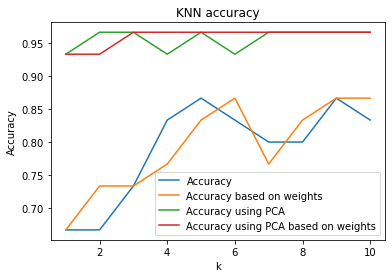

In [21]:
plt.plot(range(1, 11), accuracy_measure, label='Accuracy')
plt.plot(range(1, 11), accuracy_measure_weighted, label='Accuracy based on weights')
plt.plot(range(1, 11), accuracy_measure_Z, label='Accuracy using PCA')
plt.plot(range(1, 11), accuracy_measure_weighted_Z, label='Accuracy using PCA based on weights')
plt.title('KNN accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()